In [72]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [73]:
%%cython
from libc.stdlib cimport rand, srand, malloc, free
from libc.math cimport exp
from cython cimport boundscheck, wraparound, cdivision

cdef int MAX_MOVES = 5
cdef double INIT_MOVE_PROBS[5]
INIT_MOVE_PROBS[0] = 0.25
INIT_MOVE_PROBS[1] = 0.20
INIT_MOVE_PROBS[2] = 0.15
INIT_MOVE_PROBS[3] = 0.15
INIT_MOVE_PROBS[4] = 0.25

cdef struct AgentStats:
    int move_counts[5]
    int move_successes[5]
    double move_probs[5]
    int last_move_type

cdef struct AgentData:
    int num_items
    int num_objectives
    int attempts_per_move
    double smoothing
    int* best_observation      # [num_items]
    int move_types[5]          # 0=local, 1=global, 2=follow, 3=mutation, 4=diversity
    AgentStats stats
    int* profits               # [num_objectives * num_items]
    int* weights               # [num_objectives * num_items]
    double* capacities         # [num_objectives]

cdef inline int get_profit(int* profits, int num_objectives, int num_items, int obj, int item):
    return profits[obj * num_items + item]

cdef inline int get_weight(int* weights, int num_objectives, int num_items, int obj, int item):
    return weights[obj * num_items + item]

cdef void agent_init(AgentData* agent, int num_items, int num_objectives, int* profits, int* weights, double* capacities):
    cdef int i
    agent.num_items = num_items
    agent.num_objectives = num_objectives
    agent.attempts_per_move = 50
    agent.smoothing = 0.1
    agent.best_observation = <int*> malloc(num_items * sizeof(int))
    for i in range(num_items):
        agent.best_observation[i] = 0
    agent.stats.last_move_type = 0
    for i in range(MAX_MOVES):
        agent.stats.move_counts[i] = 1
        agent.stats.move_successes[i] = 1
        agent.stats.move_probs[i] = INIT_MOVE_PROBS[i]
        agent.move_types[i] = i
    agent.profits = profits
    agent.weights = weights
    agent.capacities = capacities

cdef void agent_free(AgentData* agent):
    if agent.best_observation != NULL:
        free(agent.best_observation)
        agent.best_observation = NULL

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef int agent_is_feasible(AgentData* agent, int* observation, int remove_idx, int add_idx):
    if agent.weights == NULL or agent.capacities == NULL:
        return 1
    if remove_idx == add_idx:
        return 0
    if observation[remove_idx] == 0 or observation[add_idx] == 1:
        return 0
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int i, item
    cdef double total_weights[10]
    for i in range(num_objectives):
        total_weights[i] = 0.0
    for item in range(num_items):
        if item != remove_idx and observation[item] == 1:
            for i in range(num_objectives):
                total_weights[i] += get_weight(agent.weights, num_objectives, num_items, i, item)
    for i in range(num_objectives):
        total_weights[i] += get_weight(agent.weights, num_objectives, num_items, i, add_idx)
        if total_weights[i] > agent.capacities[i]:
            return 0
    return 1

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_local_search_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i, obj, sel_idx, unsel_idx
    cdef int min_idx, max_idx, min_sum, max_sum, idx, sum_p
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    min_idx = items_selected[0]
    max_idx = items_unselected[0]
    min_sum = 1<<30
    max_sum = -1<<30
    for sel_idx in range(n_sel):
        idx = items_selected[sel_idx]
        sum_p = 0
        for obj in range(num_objectives):
            sum_p += get_profit(agent.profits, num_objectives, num_items, obj, idx)
        if sum_p < min_sum:
            min_sum = sum_p
            min_idx = idx
    for unsel_idx in range(n_unsel):
        idx = items_unselected[unsel_idx]
        sum_p = 0
        for obj in range(num_objectives):
            sum_p += get_profit(agent.profits, num_objectives, num_items, obj, idx)
        if sum_p > max_sum:
            max_sum = sum_p
            max_idx = idx
    move[0] = min_idx
    move[1] = max_idx

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_global_search_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    move[0] = items_selected[rand() % n_sel]
    move[1] = items_unselected[rand() % n_unsel]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_follow_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int add_candidates[250]
    cdef int remove_candidates[250]
    cdef int n_add = 0
    cdef int n_remove = 0
    cdef int i
    for i in range(num_items):
        if agent.best_observation[i] == 1 and observation[i] == 0:
            add_candidates[n_add] = i
            n_add += 1
        if agent.best_observation[i] == 0 and observation[i] == 1:
            remove_candidates[n_remove] = i
            n_remove += 1
    if n_add == 0 or n_remove == 0:
        agent_global_search_move(agent, observation, move)
        return
    move[0] = remove_candidates[rand() % n_remove]
    move[1] = add_candidates[rand() % n_add]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_mutation_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    move[0] = items_selected[rand() % n_sel]
    move[1] = items_unselected[rand() % n_unsel]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_diversity_move(
    AgentData* agent, int* observation, double* archive_objs, int archive_size, int* move, int skip_diversity):
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i, k, remove_idx, add_idx
    cdef int best_remove = 0
    cdef int best_add = 0
    cdef double best_min_dist = -1e30
    cdef double candidate_objs[250]
    cdef double candidate_f[10]
    cdef double min_dist, dist

    if skip_diversity:
        agent_mutation_move(agent, observation, move)
        return

    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0 or archive_size == 0:
        agent_mutation_move(agent, observation, move)
        return
    for k in range(agent.attempts_per_move):
        remove_idx = items_selected[rand() % n_sel]
        add_idx = items_unselected[rand() % n_unsel]
        if not agent_is_feasible(agent, observation, remove_idx, add_idx):
            continue
        for i in range(num_items):
            candidate_objs[i] = observation[i]
        candidate_objs[remove_idx] = 0
        candidate_objs[add_idx] = 1
        for i in range(num_objectives):
            candidate_f[i] = 0.0
            for j in range(num_items):
                candidate_f[i] += get_profit(agent.profits, num_objectives, num_items, i, j) * candidate_objs[j]
        min_dist = 1e30
        for i in range(archive_size):
            dist = 0.0
            for j in range(num_objectives):
                dist += (archive_objs[i * num_objectives + j] - candidate_f[j]) * (archive_objs[i * num_objectives + j] - candidate_f[j])
            dist = dist ** 0.5
            if dist < min_dist:
                min_dist = dist
        if min_dist > best_min_dist:
            best_min_dist = min_dist
            best_remove = remove_idx
            best_add = add_idx
    move[0] = best_remove
    move[1] = best_add

cdef void agent_report_move_result(AgentData* agent, int move_type, int success):
    cdef int k
    cdef double rates[5]
    cdef double exp_rates[5]
    cdef double sum_exp = 0.0
    agent.stats.move_counts[move_type] += 1
    if success:
        agent.stats.move_successes[move_type] += 1
    for k in range(MAX_MOVES):
        rates[k] = agent.stats.move_successes[k] / agent.stats.move_counts[k]
        exp_rates[k] = exp(rates[k] / agent.smoothing)
        sum_exp += exp_rates[k]
    for k in range(MAX_MOVES):
        agent.stats.move_probs[k] = 0.5 * agent.stats.move_probs[k] + 0.5 * (exp_rates[k] / sum_exp)
    sum_exp = 0.0
    for k in range(MAX_MOVES):
        sum_exp += agent.stats.move_probs[k]
    for k in range(MAX_MOVES):
        agent.stats.move_probs[k] /= sum_exp

cdef void agent_update_best(AgentData* agent, int* observation):
    cdef int i
    for i in range(agent.num_items):
        agent.best_observation[i] = observation[i]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_act(AgentData* agent, int* observation, double* archive_objs, int archive_size, int* move, int skip_diversity):
    cdef int i
    cdef double r = rand() / 2147483647.0
    cdef double cum = 0.0
    cdef int move_type = 0
    for i in range(MAX_MOVES):
        cum += agent.stats.move_probs[i]
        if r < cum:
            move_type = i
            break
    agent.stats.last_move_type = move_type
    if move_type == 0:
        agent_local_search_move(agent, observation, move)
    elif move_type == 1:
        agent_global_search_move(agent, observation, move)
    elif move_type == 2:
        agent_follow_move(agent, observation, move)
    elif move_type == 3:
        agent_mutation_move(agent, observation, move)
    elif move_type == 4:
        agent_diversity_move(agent, observation, archive_objs, archive_size, move, skip_diversity)
    else:
        agent_mutation_move(agent, observation, move)

In [74]:
import numpy as np

def load_profits_from_file(filename, num_objectives, num_items):
    profits = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 1
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 2  # skip "n:" line and weight
            profit = int(lines[idx])
            profits[obj, item] = profit
            idx += 1
    return profits

def load_weights_from_file(filename, num_objectives, num_items):
    weights = np.zeros((num_objectives, num_items), dtype=int)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 1
    for obj in range(num_objectives):
        idx += 1  # skip capacity line
        for item in range(num_items):
            idx += 1  # skip "n:" line
            weight = int(lines[idx])
            weights[obj, item] = weight
            idx += 2  # skip profit
    return weights

def load_capacities_from_file(filename, num_objectives, num_items):
    capacities = np.zeros(num_objectives)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    idx = 1
    for obj in range(num_objectives):
        capacities[obj] = float(lines[idx])
        idx += 1 + 3 * num_items
    return capacities

In [75]:
%%cython
from libc.stdlib cimport rand, srand, malloc, free
from libc.math cimport exp
from cython cimport boundscheck, wraparound, cdivision

cdef int MAX_MOVES = 5
cdef double INIT_MOVE_PROBS[5]
INIT_MOVE_PROBS[0] = 0.25
INIT_MOVE_PROBS[1] = 0.20
INIT_MOVE_PROBS[2] = 0.15
INIT_MOVE_PROBS[3] = 0.15
INIT_MOVE_PROBS[4] = 0.25

cdef struct AgentStats:
    int move_counts[5]
    int move_successes[5]
    double move_probs[5]
    int last_move_type

cdef struct AgentData:
    int num_items
    int num_objectives
    int attempts_per_move
    double smoothing
    int* best_observation      # [num_items]
    int move_types[5]          # 0=local, 1=global, 2=follow, 3=mutation, 4=diversity
    AgentStats stats
    int* profits               # [num_objectives * num_items]
    int* weights               # [num_objectives * num_items]
    double* capacities         # [num_objectives]

cdef inline int get_profit(int* profits, int num_objectives, int num_items, int obj, int item):
    return profits[obj * num_items + item]

cdef inline int get_weight(int* weights, int num_objectives, int num_items, int obj, int item):
    return weights[obj * num_items + item]

cdef void agent_init(AgentData* agent, int num_items, int num_objectives, int* profits, int* weights, double* capacities):
    cdef int i
    agent.num_items = num_items
    agent.num_objectives = num_objectives
    agent.attempts_per_move = 50
    agent.smoothing = 0.1
    agent.best_observation = <int*> malloc(num_items * sizeof(int))
    for i in range(num_items):
        agent.best_observation[i] = 0
    agent.stats.last_move_type = 0
    for i in range(MAX_MOVES):
        agent.stats.move_counts[i] = 1
        agent.stats.move_successes[i] = 1
        agent.stats.move_probs[i] = INIT_MOVE_PROBS[i]
        agent.move_types[i] = i
    agent.profits = profits
    agent.weights = weights
    agent.capacities = capacities

cdef void agent_free(AgentData* agent):
    if agent.best_observation != NULL:
        free(agent.best_observation)
        agent.best_observation = NULL

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef int agent_is_feasible(AgentData* agent, int* observation, int remove_idx, int add_idx):
    if agent.weights == NULL or agent.capacities == NULL:
        return 1
    if remove_idx == add_idx:
        return 0
    if observation[remove_idx] == 0 or observation[add_idx] == 1:
        return 0
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int i, item
    cdef double total_weights[10]
    for i in range(num_objectives):
        total_weights[i] = 0.0
    for item in range(num_items):
        if item != remove_idx and observation[item] == 1:
            for i in range(num_objectives):
                total_weights[i] += get_weight(agent.weights, num_objectives, num_items, i, item)
    for i in range(num_objectives):
        total_weights[i] += get_weight(agent.weights, num_objectives, num_items, i, add_idx)
        if total_weights[i] > agent.capacities[i]:
            return 0
    return 1

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_local_search_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i, obj, sel_idx, unsel_idx
    cdef int min_idx, max_idx, min_sum, max_sum, idx, sum_p
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    min_idx = items_selected[0]
    max_idx = items_unselected[0]
    min_sum = 1<<30
    max_sum = -1<<30
    for sel_idx in range(n_sel):
        idx = items_selected[sel_idx]
        sum_p = 0
        for obj in range(num_objectives):
            sum_p += get_profit(agent.profits, num_objectives, num_items, obj, idx)
        if sum_p < min_sum:
            min_sum = sum_p
            min_idx = idx
    for unsel_idx in range(n_unsel):
        idx = items_unselected[unsel_idx]
        sum_p = 0
        for obj in range(num_objectives):
            sum_p += get_profit(agent.profits, num_objectives, num_items, obj, idx)
        if sum_p > max_sum:
            max_sum = sum_p
            max_idx = idx
    move[0] = min_idx
    move[1] = max_idx

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_global_search_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    move[0] = items_selected[rand() % n_sel]
    move[1] = items_unselected[rand() % n_unsel]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_follow_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int add_candidates[250]
    cdef int remove_candidates[250]
    cdef int n_add = 0
    cdef int n_remove = 0
    cdef int i
    for i in range(num_items):
        if agent.best_observation[i] == 1 and observation[i] == 0:
            add_candidates[n_add] = i
            n_add += 1
        if agent.best_observation[i] == 0 and observation[i] == 1:
            remove_candidates[n_remove] = i
            n_remove += 1
    if n_add == 0 or n_remove == 0:
        agent_global_search_move(agent, observation, move)
        return
    move[0] = remove_candidates[rand() % n_remove]
    move[1] = add_candidates[rand() % n_add]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_mutation_move(AgentData* agent, int* observation, int* move):
    cdef int num_items = agent.num_items
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i
    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0:
        move[0] = 0
        move[1] = 0
        return
    move[0] = items_selected[rand() % n_sel]
    move[1] = items_unselected[rand() % n_unsel]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_diversity_move(
    AgentData* agent, int* observation, double* archive_objs, int archive_size, int* move, int skip_diversity):
    cdef int num_items = agent.num_items
    cdef int num_objectives = agent.num_objectives
    cdef int items_selected[250]
    cdef int items_unselected[250]
    cdef int n_sel = 0
    cdef int n_unsel = 0
    cdef int i, k, remove_idx, add_idx
    cdef int best_remove = 0
    cdef int best_add = 0
    cdef double best_min_dist = -1e30
    cdef double candidate_objs[250]
    cdef double candidate_f[10]
    cdef double min_dist, dist

    if skip_diversity:
        agent_mutation_move(agent, observation, move)
        return

    for i in range(num_items):
        if observation[i] == 1:
            items_selected[n_sel] = i
            n_sel += 1
        else:
            items_unselected[n_unsel] = i
            n_unsel += 1
    if n_sel == 0 or n_unsel == 0 or archive_size == 0:
        agent_mutation_move(agent, observation, move)
        return
    for k in range(agent.attempts_per_move):
        remove_idx = items_selected[rand() % n_sel]
        add_idx = items_unselected[rand() % n_unsel]
        if not agent_is_feasible(agent, observation, remove_idx, add_idx):
            continue
        for i in range(num_items):
            candidate_objs[i] = observation[i]
        candidate_objs[remove_idx] = 0
        candidate_objs[add_idx] = 1
        for i in range(num_objectives):
            candidate_f[i] = 0.0
            for j in range(num_items):
                candidate_f[i] += get_profit(agent.profits, num_objectives, num_items, i, j) * candidate_objs[j]
        min_dist = 1e30
        for i in range(archive_size):
            dist = 0.0
            for j in range(num_objectives):
                dist += (archive_objs[i * num_objectives + j] - candidate_f[j]) * (archive_objs[i * num_objectives + j] - candidate_f[j])
            dist = dist ** 0.5
            if dist < min_dist:
                min_dist = dist
        if min_dist > best_min_dist:
            best_min_dist = min_dist
            best_remove = remove_idx
            best_add = add_idx
    move[0] = best_remove
    move[1] = best_add

cdef void agent_report_move_result(AgentData* agent, int move_type, int success):
    cdef int k
    cdef double rates[5]
    cdef double exp_rates[5]
    cdef double sum_exp = 0.0
    agent.stats.move_counts[move_type] += 1
    if success:
        agent.stats.move_successes[move_type] += 1
    for k in range(MAX_MOVES):
        rates[k] = agent.stats.move_successes[k] / agent.stats.move_counts[k]
        exp_rates[k] = exp(rates[k] / agent.smoothing)
        sum_exp += exp_rates[k]
    for k in range(MAX_MOVES):
        agent.stats.move_probs[k] = 0.5 * agent.stats.move_probs[k] + 0.5 * (exp_rates[k] / sum_exp)
    sum_exp = 0.0
    for k in range(MAX_MOVES):
        sum_exp += agent.stats.move_probs[k]
    for k in range(MAX_MOVES):
        agent.stats.move_probs[k] /= sum_exp

cdef void agent_update_best(AgentData* agent, int* observation):
    cdef int i
    for i in range(agent.num_items):
        agent.best_observation[i] = observation[i]

@boundscheck(False)
@wraparound(False)
@cdivision(True)
cdef void agent_act(AgentData* agent, int* observation, double* archive_objs, int archive_size, int* move, int skip_diversity):
    cdef int i
    cdef double r = rand() / 2147483647.0
    cdef double cum = 0.0
    cdef int move_type = 0
    for i in range(MAX_MOVES):
        cum += agent.stats.move_probs[i]
        if r < cum:
            move_type = i
            break
    agent.stats.last_move_type = move_type
    if move_type == 0:
        agent_local_search_move(agent, observation, move)
    elif move_type == 1:
        agent_global_search_move(agent, observation, move)
    elif move_type == 2:
        agent_follow_move(agent, observation, move)
    elif move_type == 3:
        agent_mutation_move(agent, observation, move)
    elif move_type == 4:
        agent_diversity_move(agent, observation, archive_objs, archive_size, move, skip_diversity)
    else:
        agent_mutation_move(agent, observation, move)

In [76]:
import numpy as np

nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "why.txt"

run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/1 -- 250.2.txt nbitems=250 nf=2 => why.txt
Optimization completed.


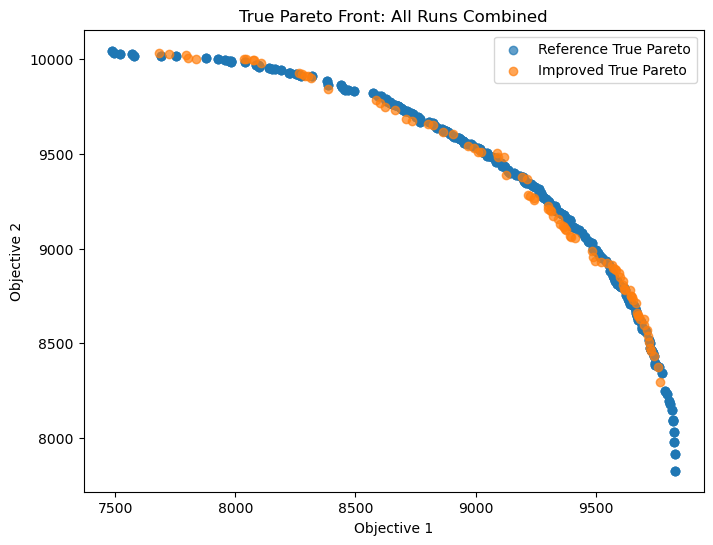

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("why.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

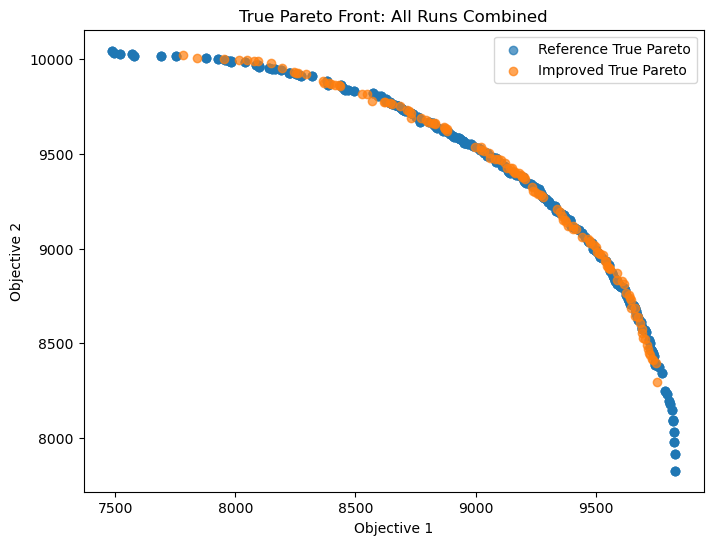

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("testit.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

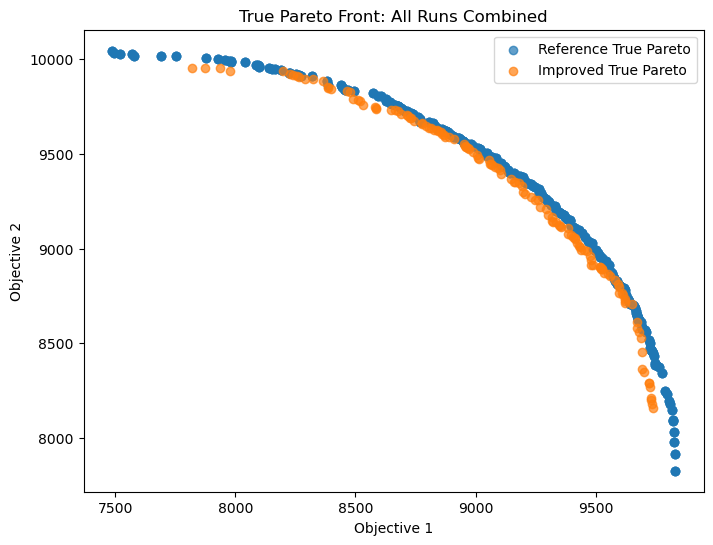

In [63]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("xxxxx.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [103]:
# Set your parameters and file names
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "oups.txt"

# Load data for agent
profits = load_profits_from_file(instance_file.decode(), num_objectives, nbitems)
weights = load_weights_from_file(instance_file.decode(), num_objectives, nbitems)
capacities = load_capacities_from_file(instance_file.decode(), num_objectives, nbitems)

# Create agent with all info
agent = IntelligentAgent(nbitems, num_objectives, profits=profits, weights=weights, capacities=capacities)

# Register agent with Cython core
set_agent(agent)

# Run the optimizer
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => oups.txt
Optimization completed.


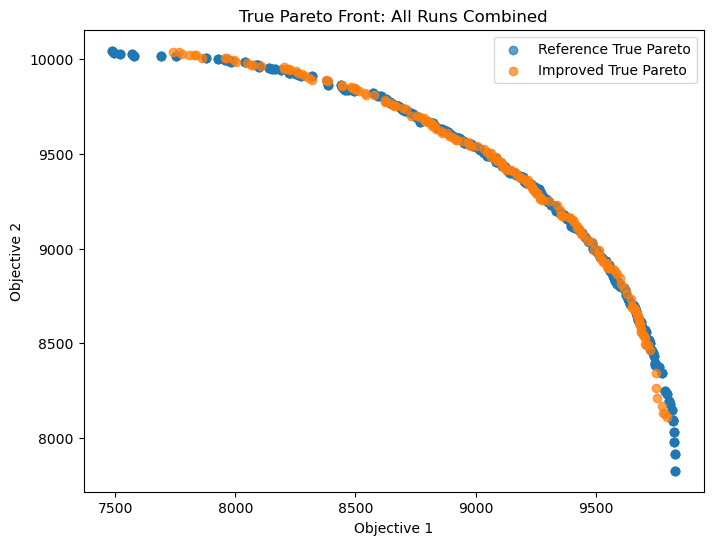

In [104]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("oups.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [8]:
# Set your parameters and file names
nbitems = 250
num_objectives = 2
instance_file = b"250.2.txt"
weights_file = b"Weights_2obj_FQ200.txt"
output_file = "output.txt"

# Load data for agent
profits = load_profits_from_file("250.2.txt", num_objectives, nbitems)
weights = load_weights_from_file("250.2.txt", num_objectives, nbitems)
capacities = load_capacities_from_file("250.2.txt", num_objectives, nbitems)

# Create agent with all info
agent = IntelligentAgent(nbitems, num_objectives, profits=profits, weights=weights, capacities=capacities)

# Register agent with Cython core
set_agent(agent)

# Run the optimizer
run_moacp(instance_file, weights_file, nbitems, num_objectives, output_file)
print("Optimization completed.")

RUN 1/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 2/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 3/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 4/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 5/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 6/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 7/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 8/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 9/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
RUN 10/10 -- 250.2.txt nbitems=250 nf=2 => output.txt
Optimization completed.


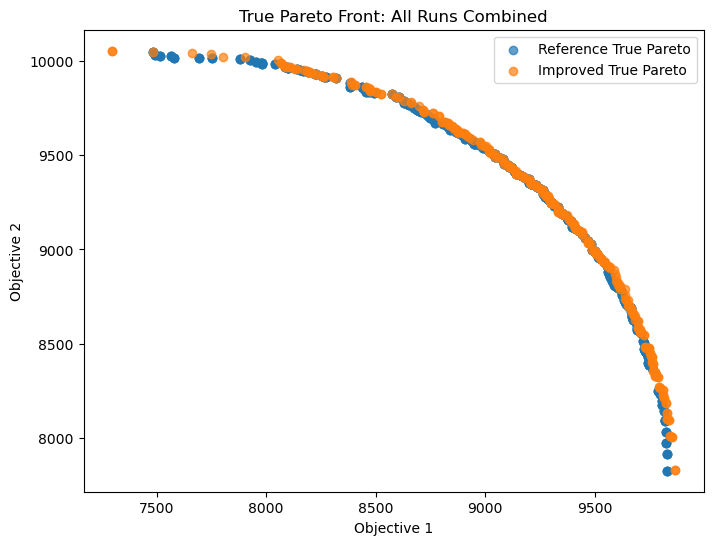

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def load_pareto_front(filename):
    points = []
    with open(filename) as f:
        for line in f:
            line = line.strip()
            if line:
                points.append([float(x) for x in line.split()])
    return np.array(points)

def is_dominated(point, others):
    """Returns True if point is dominated by any row in others"""
    return np.any(np.all(others >= point, axis=1) & np.any(others > point, axis=1))

def get_pareto_front(points):
    mask = np.ones(len(points), dtype=bool)
    for i, p in enumerate(points):
        others = np.delete(points, i, axis=0)
        if is_dominated(p, others):
            mask[i] = False
    return points[mask]

# Load and merge all runs' points for each result file
ref_points = load_pareto_front("2502_Resulats.txt")
new_points = load_pareto_front("output.txt")

# Get the true Pareto front for each
ref_pareto = get_pareto_front(ref_points)
new_pareto = get_pareto_front(new_points)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(ref_pareto[:,0], ref_pareto[:,1], label="Reference True Pareto", alpha=0.7)
plt.scatter(new_pareto[:,0], new_pareto[:,1], label="Improved True Pareto", alpha=0.7)
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()
plt.title("True Pareto Front: All Runs Combined")
plt.show()

In [1]:
!conda install -c conda-forge pymoo

Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... failed with initial frozen solve. Retrying with flexible solve.



The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/win-64::anaconda==2022.10=py39_0
  - defaults/win-64::anaconda-client==1.11.0=py39haa95532_0
  - defaults/win-64::anaconda-navigator==2.3.1=py39haa95532_0
  - defaults/win-64::anaconda-project==0.11.1=py39haa95532_0
  - defaults/win-64::argon2-cffi-bindings==21.2.0=py39h2bbff1b_0
  - defaults/win-64::astropy==5.1=py39h080aedc_0
  - defaults/noarch::automat==20.2.0=py_0
  - defaults/noarch::backports.functools_lru_cache==1.6.4=pyhd3eb1b0_0
  - defaults/win-64::bcrypt==3.2.0=py39h2bbff1b_1
  - defaults/win-64::bkcharts==0.2=py39haa95532_1
  - defaults/win-64::bokeh==2.4.3=py39haa95532_0
  - defaults/win-64::boto3==1.24.28=py39haa95532_0
  - defaults/win-64::botocore==1.27.28=py39haa95532_0
  - defaults/win-64::bottleneck==1.3.5=py39h080aedc_0
  - defaults/win-64::brotlipy==0.7.0=py39h2bbff1b_1003
  - defaults/win-64::clyent==1.2.2=py39haa95532_1
  

In [29]:
import numpy as np
from pymoo.indicators.hv import HV

# Use your previously calculated Pareto fronts
ref = ref_pareto
new = new_pareto

# Calculate the reference point (must be worse than any point in both sets)
ref_point = np.max(np.vstack([ref, new]), axis=0) + 1

# Instantiate HV indicator
hv = HV(ref_point=ref_point)

# Compute and print hypervolumes
print("Reference HV:", hv(ref))
print("Improved HV:", hv(new))

Reference HV: 1199470.0
Improved HV: 1159322.0


In [59]:
import numpy as np

# --- IntelligentAgent as before, but with LLM-aware meta_adapt ---

class IntelligentAgent:
    def __init__(
        self,
        num_items,
        num_objectives,
        profits=None,
        weights=None,
        capacities=None,
        attempts_per_move=50,
        smoothing=0.1,
    ):
        self.num_items = num_items
        self.num_objectives = num_objectives
        self.profits = profits
        self.weights = weights
        self.capacities = capacities
        self.attempts_per_move = attempts_per_move
        self.smoothing = smoothing
        self.move_types = ["local_search", "global_search", "follow", "mutation", "diversity"]
        self.move_counts = {k: 1 for k in self.move_types}
        self.move_successes = {k: 1 for k in self.move_types}
        self.move_probs = np.array([0.25, 0.20, 0.15, 0.15, 0.25], dtype=np.float64)
        self.best_observation = None
        self.last_move_type = None

    def act(self, observation, context=None):
        archive_objs = None
        if context is not None and "archive_objs" in context:
            archive_objs = context["archive_objs"]

        move_idx = np.random.choice(len(self.move_types), p=self.move_probs)
        move_type = self.move_types[move_idx]
        self.last_move_type = move_type

        if move_type == "diversity" and archive_objs is not None and self.profits is not None:
            move = self.diversity_move(observation, archive_objs)
            if move is not None:
                return move

        for _ in range(self.attempts_per_move):
            if move_type == "local_search":
                move = self.local_search_move(observation)
            elif move_type == "global_search":
                move = self.global_search_move(observation)
            elif move_type == "follow":
                move = self.follow_move(observation)
            elif move_type == "mutation":
                move = self.mutation_move(observation)
            else:
                continue

            if self._is_feasible(observation, move):
                return move

        for _ in range(self.attempts_per_move * 2):
            move = self.mutation_move(observation)
            if self._is_feasible(observation, move):
                return move

        return (0, 0)

    def report_move_result(self, move_type, success):
        if move_type is None:
            move_type = self.last_move_type
        if move_type not in self.move_types:
            return
        self.move_counts[move_type] += 1
        if success:
            self.move_successes[move_type] += 1
        rates = np.array(
            [self.move_successes[k] / self.move_counts[k] for k in self.move_types],
            dtype=np.float64,
        )
        exp_rates = np.exp(rates / self.smoothing)
        new_probs = exp_rates / np.sum(exp_rates)
        self.move_probs = 0.5 * self.move_probs + 0.5 * new_probs
        self.move_probs = self.move_probs / np.sum(self.move_probs)

    def update_best(self, observation):
        self.best_observation = observation.copy()

    def meta_adapt(self, meta_info):
        # This method can be called by the LLM agent to adjust strategies
        if "move_probs" in meta_info:
            self.move_probs = np.array(meta_info["move_probs"])
            self.move_probs = self.move_probs / np.sum(self.move_probs)
        if "new_move_types" in meta_info:
            for m in meta_info["new_move_types"]:
                if m not in self.move_types:
                    self.move_types.append(m)
        # Example: LLM could inject new moves here

    def local_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        remove_idx = int(items_selected[int(np.argmin(profs_selected))])
        add_idx = items_unselected[np.argmax(profs_unselected)]
        return int(remove_idx), int(add_idx)

    def global_search_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0 or self.profits is None:
            return 0, 0
        profs_selected = np.sum(self.profits[:, items_selected], axis=0)
        profs_unselected = np.sum(self.profits[:, items_unselected], axis=0)
        ps = profs_selected + 1e-9
        pu = profs_unselected + 1e-9
        remove_idx = np.random.choice(items_selected, p=ps / np.sum(ps))
        add_idx = np.random.choice(items_unselected, p=pu / np.sum(pu))
        return int(remove_idx), int(add_idx)

    def follow_move(self, observation):
        if self.best_observation is None:
            return self.mutation_move(observation)
        diff = self.best_observation - observation
        add_candidates = np.where((diff == 1) & (observation == 0))[0]
        remove_candidates = np.where((diff == -1) & (observation == 1))[0]
        if len(add_candidates) == 0 or len(remove_candidates) == 0:
            return self.mutation_move(observation)
        add_idx = np.random.choice(add_candidates)
        remove_idx = np.random.choice(remove_candidates)
        return int(remove_idx), int(add_idx)

    def mutation_move(self, observation):
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return 0, 0
        remove_idx = int(np.random.choice(items_selected))
        add_idx = int(np.random.choice(items_unselected))
        return remove_idx, add_idx

    def diversity_move(self, observation, archive_objs):
        best_move = None
        best_min_dist = -np.inf
        items_selected = np.where(observation == 1)[0]
        items_unselected = np.where(observation == 0)[0]
        if len(items_selected) == 0 or len(items_unselected) == 0:
            return None
        for _ in range(self.attempts_per_move):
            remove_idx = int(np.random.choice(items_selected))
            add_idx = int(np.random.choice(items_unselected))
            if not self._is_feasible(observation, (remove_idx, add_idx)):
                continue
            candidate = observation.copy()
            candidate[remove_idx] = 0
            candidate[add_idx] = 1
            candidate_objs = np.sum(self.profits * candidate, axis=1)
            dists = np.linalg.norm(archive_objs - candidate_objs, axis=1)
            min_dist = np.min(dists)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_move = (remove_idx, add_idx)
        return best_move

    def _is_feasible(self, observation, move):
        if self.weights is None or self.capacities is None:
            return True
        remove_idx, add_idx = move
        if remove_idx == add_idx:
            return False
        items = observation.copy()
        if items[remove_idx] == 0 or items[add_idx] == 1:
            return False
        items[remove_idx] = 0
        items[add_idx] = 1
        total_weights = np.sum(self.weights * items, axis=1)
        feasible = np.all(total_weights <= self.capacities)
        return feasible

# --- Simulated LLM Reflection Function ---
def simulated_llm_reflection(agent_stats):
    """
    Simulates an LLM's role in MHRE: Given agent stats, return new move probabilities
    or suggest new moves or architecture strategies.
    """
    # Example logic: If diversity is low, boost mutation and diversity
    if agent_stats['archive_diversity'] < 1.5:
        # LLM suggests: Increase mutation and diversity moves
        suggestion = {
            'move_probs': [0.15, 0.10, 0.10, 0.40, 0.25],  # More mutation!
        }
    else:
        # LLM suggests: Focus more on local/global
        suggestion = {
            'move_probs': [0.30, 0.25, 0.10, 0.15, 0.20],
        }
    return suggestion

def measure_archive_diversity(archive_objs):
    """Simple diversity metric: average Euclidean distance between archive solutions."""
    if len(archive_objs) < 2:
        return 0.0
    arr = np.array(archive_objs)
    dists = []
    for i in range(len(arr)):
        for j in range(i+1, len(arr)):
            dists.append(np.linalg.norm(arr[i]-arr[j]))
    return np.mean(dists)

# --- Main Optimization Loop with LLM Reflection ---
def main():
    np.random.seed(42)
    num_items = 10
    num_objectives = 2
    profits = np.random.randint(1, 10, size=(num_objectives, num_items))
    weights = np.random.randint(1, 5, size=(num_objectives, num_items))
    capacities = np.array([15, 12])
    agent = IntelligentAgent(
        num_items=num_items,
        num_objectives=num_objectives,
        profits=profits,
        weights=weights,
        capacities=capacities,
        attempts_per_move=20,
        smoothing=0.15
    )
    population = [np.random.randint(0, 2, size=num_items) for _ in range(8)]
    archive = []
    archive_objs = []

    for generation in range(50):
        for obs in population:
            context = {"archive_objs": np.array([np.sum(profits * p, axis=1) for p in archive]) if archive else None}
            move = agent.act(obs, context)
            candidate = obs.copy()
            remove_idx, add_idx = move
            if candidate[remove_idx] == 1 and candidate[add_idx] == 0:
                candidate[remove_idx] = 0
                candidate[add_idx] = 1
            candidate_obj = np.sum(profits * candidate, axis=1)
            total_weights = np.sum(weights * candidate, axis=1)
            feasible = np.all(total_weights <= capacities)
            success = False
            if feasible:
                # Pareto check (simple, not full dominance logic)
                dominated = False
                for other_obj in archive_objs:
                    if np.all(other_obj >= candidate_obj) and np.any(other_obj > candidate_obj):
                        dominated = True
                        break
                if not dominated:
                    archive.append(candidate.copy())
                    archive_objs.append(candidate_obj)
                    agent.update_best(candidate)
                    success = True
            agent.report_move_result(agent.last_move_type, success)

        # MHRE/LLM Reflection Step every 10 generations
        if generation > 0 and generation % 10 == 0:
            agent_stats = {
                'move_counts': agent.move_counts,
                'move_successes': agent.move_successes,
                'move_probs': agent.move_probs,
                'archive_diversity': measure_archive_diversity(archive_objs),
            }
            # Call simulated LLM
            suggestion = simulated_llm_reflection(agent_stats)
            agent.meta_adapt(suggestion)
            print(f"Generation {generation}: LLM reflection updated move_probs to {agent.move_probs}")

    # Print final archive
    print("Final Pareto Archive (objectives):")
    print(np.array(archive_objs))

if __name__ == "__main__":
    main()

Generation 10: LLM reflection updated move_probs to [0.15 0.1  0.1  0.4  0.25]
Generation 20: LLM reflection updated move_probs to [0.15 0.1  0.1  0.4  0.25]
Generation 30: LLM reflection updated move_probs to [0.15 0.1  0.1  0.4  0.25]
Generation 40: LLM reflection updated move_probs to [0.15 0.1  0.1  0.4  0.25]
Final Pareto Archive (objectives):
[]
